<a href="https://colab.research.google.com/github/CarlosRochaCx/MNA/blob/main/MNA_IAyAA_Actividad_Pronosticos_Series_de_Tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr Luis Eduardo Falcón Morales**
### **Tecnológico de Monterrey**
## **Actividad Individual Semana 9: Pronósticos con Series de Tiempo**


#### **Nombre:** Carlos Alberto Rocha Chávez
#### **Matrícula:** A01796914

Modelos para predicción de un problema de serie de tiempo:

* **1. Modelo ingenuo**
* **2. Modelo ARIMA**
* **3. Modelo Prophet**
* **4. Modelo LSTM**

In [52]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import warnings
warnings.filterwarnings('ignore')

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MNA - Maestría en Inteligencia Artificial Aplicada/Inteligencia Artificial y Aprendizaje Automático/Tareas/Actividad Semana 9/monthly_champagne_sales.csv")

df.head().T

,0,1,2,3,4
Month,1964-01,1964-02,1964-03,1964-04,1964-05
Sales,2815,2672,2755,2721,2946


In [55]:
df.shape

(105, 2)

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Month   105 non-null    object
 1   Sales   105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [57]:
# Asegurarse de que la columna Month sea datetime
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# División: Entrenamiento (hasta 12 meses antes del final) y prueba
train = df[:-12]
test = df[-12:]

#### Modelo Ingenuo (Naive Forecast)

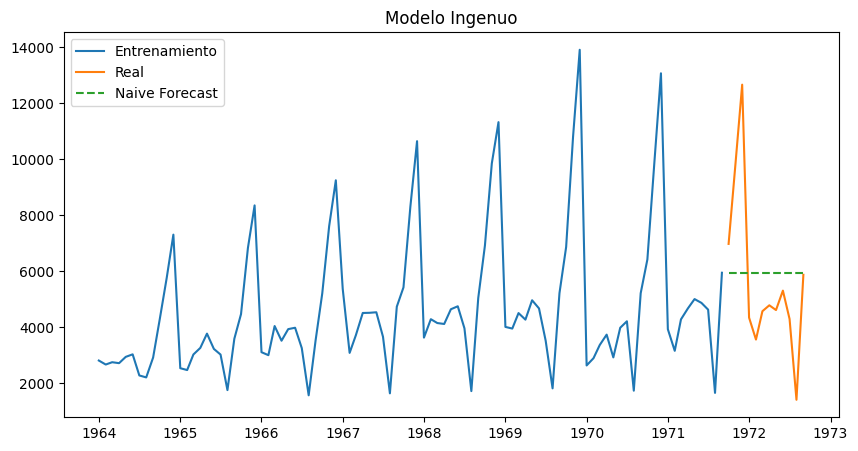

In [58]:
# Último valor del entrenamiento
last_value = train['Sales'].iloc[-1]

# Pronóstico para cada mes del test
naive_forecast = np.repeat(last_value, len(test))

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train['Sales'], label='Entrenamiento')
plt.plot(test.index, test['Sales'], label='Real')
plt.plot(test.index, naive_forecast, label='Naive Forecast', linestyle='--')
plt.title("Modelo Ingenuo")
plt.legend()
plt.show()

#### Modelo ARIMA

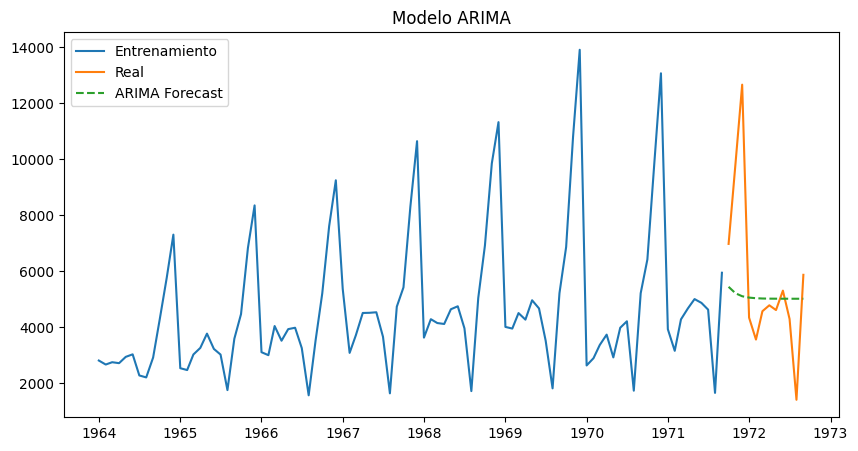

In [59]:
# Entrenamiento del modelo ARIMA (se puede ajustar el orden según AIC/BIC o pruebas ADF)
arima_model = ARIMA(train['Sales'], order=(1,1,1))  # p=1, d=1, q=1 como ejemplo inicial
arima_result = arima_model.fit()

# Pronóstico
arima_forecast = arima_result.forecast(steps=12)

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(train['Sales'], label='Entrenamiento')
plt.plot(test['Sales'], label='Real')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--')
plt.title("Modelo ARIMA")
plt.legend()
plt.show()

#### Modelo Prophet

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpctjzq5yy/zl0gjrgj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpctjzq5yy/6uy0uhvw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34853', 'data', 'file=/tmp/tmpctjzq5yy/zl0gjrgj.json', 'init=/tmp/tmpctjzq5yy/6uy0uhvw.json', 'output', 'file=/tmp/tmpctjzq5yy/prophet_model7r0oh2ql/prophet_model-20250617030316.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:03:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:03:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


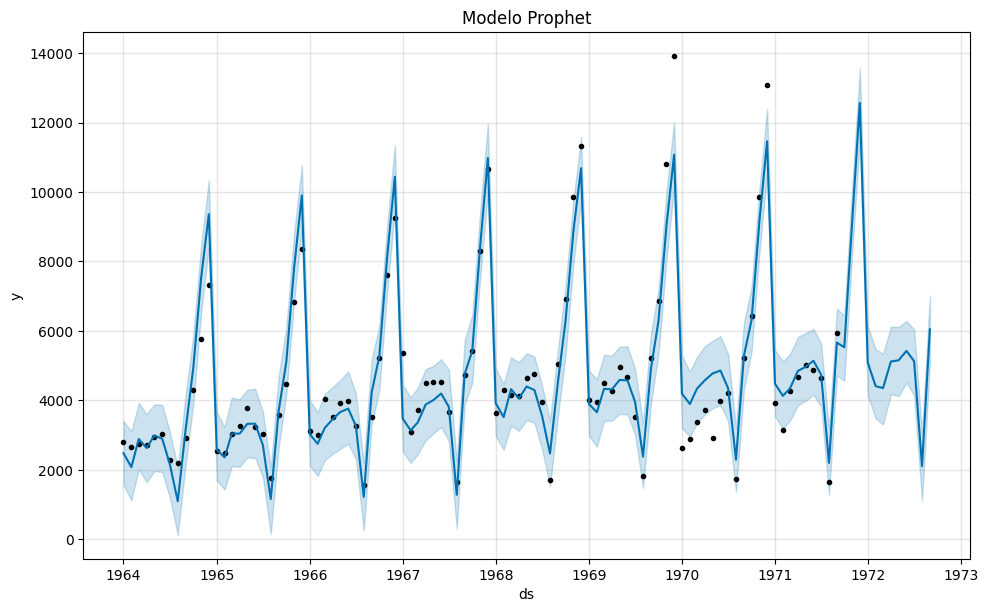

In [60]:
# Convertir para Prophet
df_prophet = df.reset_index().rename(columns={'Month': 'ds', 'Sales': 'y'})

# Separar entrenamiento y prueba
train_prophet = df_prophet[:-12]
test_prophet = df_prophet[-12:]

# Crear y ajustar el modelo
prophet = Prophet()
prophet.fit(train_prophet)

# Crear futuro (12 meses)
future = prophet.make_future_dataframe(periods=12, freq='M')
forecast = prophet.predict(future)

# Visualizar
prophet.plot(forecast)
plt.title("Modelo Prophet")
plt.show()

#### Modelo LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step


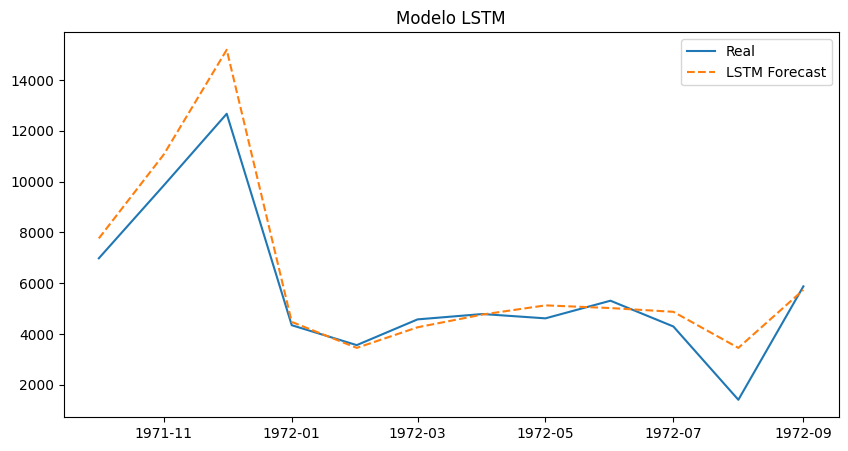

In [61]:
# Escalado
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Sales']])

# Crear secuencias para LSTM
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 12
X, y = create_sequences(scaled_data, n_steps)

# Separar entrenamiento y prueba
X_train, y_train = X[:-12], y[:-12]
X_test, y_test = X[-12:], y[-12:]

# LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_steps, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=200, verbose=0)

# Pronóstico
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Visualizar
plt.figure(figsize=(10, 5))
plt.plot(df.index[-12:], test['Sales'], label='Real')
plt.plot(df.index[-12:], y_pred, label='LSTM Forecast', linestyle='--')
plt.title("Modelo LSTM")
plt.legend()
plt.show()

#### Conclusión

En este trabajo usamos varios modelos para predecir una serie de tiempo, es decir, una secuencia de datos que cambia con el paso del tiempo. Probamos cuatro modelos distintos: uno muy simple llamado modelo ingenuo, y otros más avanzados como ARIMA, Prophet y una red neuronal llamada LSTM.

El modelo ingenuo es el más básico, ya que simplemente repite el último valor conocido como si fuera el siguiente. Aunque no es muy preciso, nos ayuda a tener una idea base para comparar los demás modelos.

El modelo ARIMA es un modelo estadístico clásico que funciona bien cuando los datos no cambian demasiado con el tiempo o no tienen muchos altibajos. Puede dar buenos resultados si se prepara bien la información antes de usarlo, pero puede ser algo complejo de ajustar correctamente.

Prophet, creado por Facebook, es más moderno y muy fácil de usar. Es bueno para detectar patrones como subidas y bajadas regulares (por ejemplo, ventas que aumentan en ciertas temporadas). Además, permite visualizar los resultados de forma clara, lo cual ayuda a entender qué está pasando con los datos.

Por último, el modelo LSTM es una red neuronal que puede aprender relaciones más complejas entre los datos. Es útil cuando hay muchos cambios o comportamientos difíciles de detectar. Sin embargo, necesita más datos y más tiempo de entrenamiento, además de requerir conocimientos un poco más avanzados.

Este ejercicio fue muy útil porque nos permitió conocer y comparar diferentes formas de hacer predicciones con series de tiempo. Aprendimos que no todos los modelos sirven para todo tipo de datos, y que cada uno tiene sus ventajas y desventajas. También nos ayudó a practicar el uso de herramientas actuales de inteligencia artificial y a entender mejor cómo analizar información a lo largo del tiempo. En el mundo real, este tipo de análisis se usa mucho en áreas como finanzas, ventas, clima, entre otras, por lo que es muy valioso dominar estos métodos.

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**